In [ ]:
# Install required packages (uncomment if running in Colab)
# !pip install tensorflow matplotlib scikit-learn seaborn

# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings

# Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

# Mount Google Drive (required for saving model)
from google.colab import drive
drive.mount('/content/drive')

# Create models directory in Google Drive if it doesn't exist
models_dir = '/content/drive/My Drive/models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created directory: {models_dir}")
else:
    print(f"Directory already exists: {models_dir}")


TensorFlow version: 2.19.0
Keras version: 3.10.0


## 1. Data Loading and Preprocessing

In this section, we'll load the MNIST dataset and apply comprehensive preprocessing including normalization, reshaping, and data exploration.

In [3]:
# Load the MNIST dataset
print("Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Display dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Data exploration
print(f"\nDataset Statistics:")
print(f"Number of training samples: {x_train.shape[0]:,}")
print(f"Number of test samples: {x_test.shape[0]:,}")
print(f"Image dimensions: {x_train.shape[1]} x {x_train.shape[2]}")
print(f"Number of classes: {len(np.unique(y_train))}")
print(f"Classes: {np.unique(y_train)}")

# Check data types and ranges
print(f"\nData type: {x_train.dtype}")
print(f"Pixel value range: {x_train.min()} - {x_train.max()}")

# Normalize pixel values to [0, 1] range
print("\nNormalizing pixel values...")
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape for CNN (add channel dimension)
print("Reshaping data for CNN...")
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert labels to categorical (one-hot encoding)
print("Converting labels to categorical...")
y_train_cat = keras.utils.to_categorical(y_train, num_classes=10)
y_test_cat = keras.utils.to_categorical(y_test, num_classes=10)

print(f"\nAfter preprocessing:")
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train_cat.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test_cat.shape}")
print(f"Normalized pixel range: {x_train.min():.3f} - {x_train.max():.3f}")

Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)

Dataset Statistics:
Number of training samples: 60,000
Number of test samples: 10,000
Image dimensions: 28 x 28
Number of classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]

Data type: uint8
Pixel value range: 0 - 255

Normalizing pixel values...
Reshaping data for CNN...
Converting labels to categorical...

After preprocessing:
Training data shape: (60000, 28, 28, 1)
Training labels shape: (60000, 10)
Test data shape: (10000, 28, 28, 1)
Test labels shape: (10000, 10)
Normalized pixel range: 0.000 - 1.000


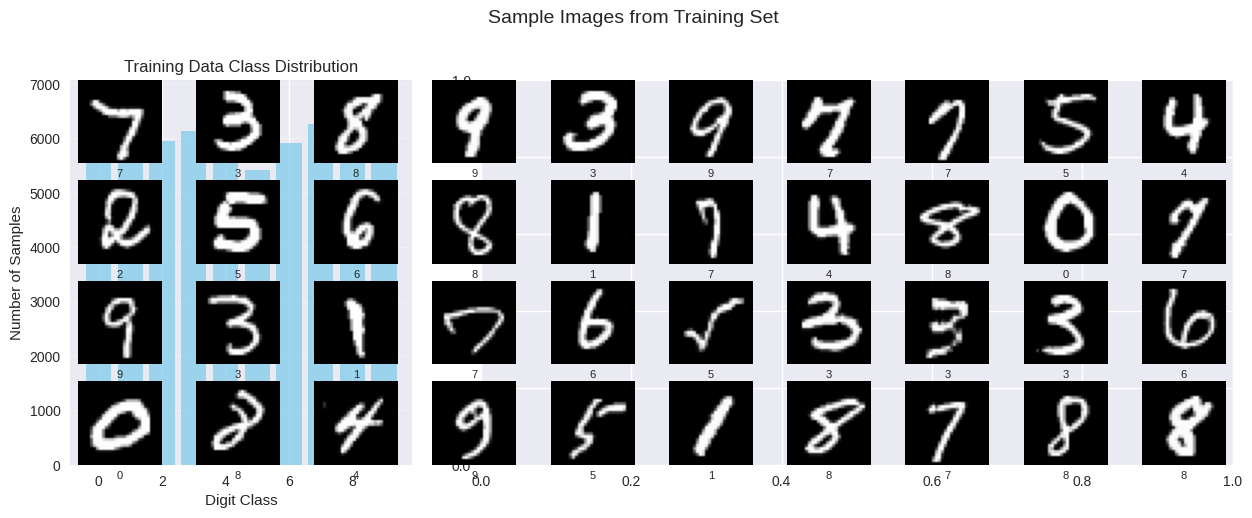


Class distribution in training set:
Digit 0: 5,923 samples (9.9%)
Digit 1: 6,742 samples (11.2%)
Digit 2: 5,958 samples (9.9%)
Digit 3: 6,131 samples (10.2%)
Digit 4: 5,842 samples (9.7%)
Digit 5: 5,421 samples (9.0%)
Digit 6: 5,918 samples (9.9%)
Digit 7: 6,265 samples (10.4%)
Digit 8: 5,851 samples (9.8%)
Digit 9: 5,949 samples (9.9%)


In [4]:
# Visualize class distribution
plt.figure(figsize=(15, 5))

# Plot 1: Class distribution
plt.subplot(1, 3, 1)
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, color='skyblue', alpha=0.8)
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('Training Data Class Distribution')
plt.grid(axis='y', alpha=0.3)

# Plot 2: Sample images grid
plt.subplot(1, 3, (2, 3))
ROWS, COLS = 4, 10
sample_indices = np.random.choice(len(x_train), ROWS * COLS, replace=False)

for i, idx in enumerate(sample_indices):
    plt.subplot(ROWS, COLS, i + 1)
    # Use original normalized data for display (remove channel dimension)
    plt.imshow(x_train[idx].squeeze(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f'{y_train[idx]}', fontsize=8)

plt.suptitle('Sample Images from Training Set', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Display detailed statistics
print("\nClass distribution in training set:")
for digit in range(10):
    count = np.sum(y_train == digit)
    percentage = (count / len(y_train)) * 100
    print(f"Digit {digit}: {count:,} samples ({percentage:.1f}%)")

Visualizing different samples of digit '2':


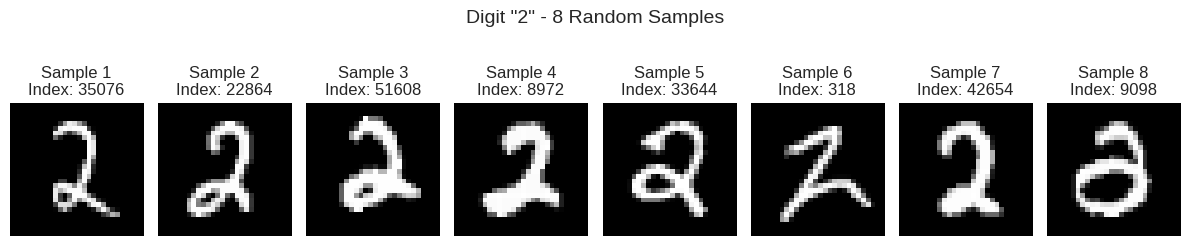

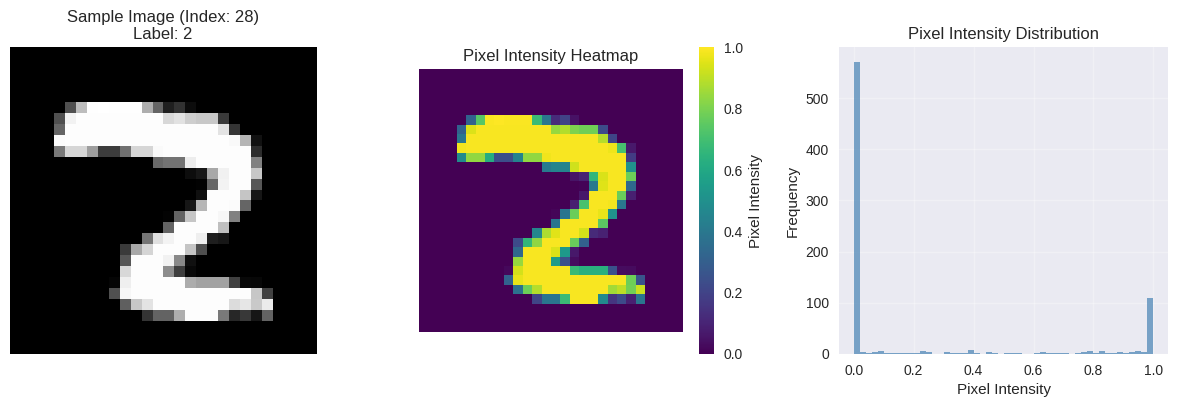


Image analysis for sample #28:
Label: 2
Image shape: (28, 28)
Min pixel value: 0.000
Max pixel value: 1.000
Mean pixel value: 0.208
Standard deviation: 0.378


In [5]:
# Interactive digit visualization
def visualize_digit_samples(digit_class, num_samples=5):
    """Visualize multiple samples of a specific digit class"""
    indices = np.where(y_train == digit_class)[0]
    sample_indices = np.random.choice(indices, min(num_samples, len(indices)), replace=False)

    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_train[idx].squeeze(), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Sample {i+1}\nIndex: {idx}')

    plt.suptitle(f'Digit "{digit_class}" - {num_samples} Random Samples', fontsize=14)
    plt.tight_layout()
    plt.show()

# Example: Visualize samples of digit 2
print("Visualizing different samples of digit '2':")
visualize_digit_samples(2, 8)

# Show pixel intensity analysis for a single image
sample_idx = 28
sample_image = x_train[sample_idx].squeeze()
sample_label = y_train[sample_idx]

plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(sample_image, cmap='gray')
plt.title(f'Sample Image (Index: {sample_idx})\nLabel: {sample_label}')
plt.xticks([])
plt.yticks([])

# Pixel intensity heatmap
plt.subplot(1, 3, 2)
plt.imshow(sample_image, cmap='viridis')
plt.colorbar(label='Pixel Intensity')
plt.title('Pixel Intensity Heatmap')
plt.xticks([])
plt.yticks([])

# Pixel intensity distribution
plt.subplot(1, 3, 3)
plt.hist(sample_image.flatten(), bins=50, alpha=0.7, color='steelblue')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nImage analysis for sample #{sample_idx}:")
print(f"Label: {sample_label}")
print(f"Image shape: {sample_image.shape}")
print(f"Min pixel value: {sample_image.min():.3f}")
print(f"Max pixel value: {sample_image.max():.3f}")
print(f"Mean pixel value: {sample_image.mean():.3f}")
print(f"Standard deviation: {sample_image.std():.3f}")

## 2. Enhanced CNN Model Architecture

We'll build an improved CNN model with the following enhancements:
- **Batch Normalization** for training stability
- **Dropout Layers** for regularization
- **Multiple Convolutional Blocks** for better feature extraction
- **Proper Input Layer** to avoid warnings

In [6]:
def create_enhanced_cnn_model():
    """
    Create an enhanced CNN model with improved architecture and regularization
    """
    model = keras.Sequential([
        # Input layer (proper way to define input shape)
        layers.Input(shape=(28, 28, 1)),

        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),

        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])

    return model

# Create the enhanced model
print("Creating enhanced CNN model...")
model = create_enhanced_cnn_model()

# Compile the model with optimized settings
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

# Display model architecture
print("\nModel Architecture:")
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")

# Visualize model architecture
keras.utils.plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=150
)
print("\nModel architecture diagram saved as 'model_architecture.png'")

Creating enhanced CNN model...

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,487,466 (13.30 MB)

 Trainable params: 3,485,994 (13.30 MB)

 Non-trainable params: 1,472 (5.75 KB)


Total trainable parameters: 3,487,466

Model architecture diagram saved as 'model_architecture.png'


## 3. Advanced Training Configuration

We'll implement advanced training techniques including:
- **Early Stopping** to prevent overfitting
- **Learning Rate Scheduling** for better convergence
- **Model Checkpointing** to save the best model
- **Data Augmentation** for improved generalization

In [ ]:
# Define callbacks for enhanced training
def create_callbacks():
    """Create training callbacks for better model performance"""
    
    # Define the exact path that Digit-1.ipynb expects
    model_save_path = '/content/drive/My Drive/models/mnist_cnn_model.h5'

    callbacks = [
        # Early stopping to prevent overfitting
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1,
            mode='min'
        ),

        # Reduce learning rate when loss plateaus
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-7,
            verbose=1,
            mode='min'
        ),

        # Save best model checkpoint to Google Drive
        ModelCheckpoint(
            model_save_path,
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            verbose=1,
            mode='max'
        )
    ]
    
    print(f"Model will be saved to: {model_save_path}")
    return callbacks

# Create data augmentation (optional - for even better performance)
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,        # Randomly rotate images by 10 degrees
    width_shift_range=0.1,    # Randomly shift images horizontally
    height_shift_range=0.1,   # Randomly shift images vertically
    zoom_range=0.1,           # Randomly zoom images
    fill_mode='nearest'       # Fill pixels after transformation
)

# Fit the data generator
print("Setting up data augmentation...")
datagen.fit(x_train)

# Create callbacks
callbacks = create_callbacks()

# Training configuration
EPOCHS = 10
BATCH_SIZE = 128
VALIDATION_SPLIT = 0.15

print(f"\nTraining Configuration:")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Validation Split: {VALIDATION_SPLIT}")
print(f"Training samples: {int(len(x_train) * (1 - VALIDATION_SPLIT)):,}")
print(f"Validation samples: {int(len(x_train) * VALIDATION_SPLIT):,}")

# Start training
print(f"\nStarting model training...")
print("=" * 60)

# Train with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train_cat, batch_size=BATCH_SIZE),
    steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_test, y_test_cat),  # Use test set for validation monitoring
    callbacks=callbacks,
    verbose=1
)

print("=" * 60)
print("Training completed!")


Setting up data augmentation...

Training Configuration:
Epochs: 10
Batch Size: 128
Validation Split: 0.15
Training samples: 51,000
Validation samples: 9,000

Starting model training...
Epoch 1/10
467/468 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7655 - loss: 0.7718 - top_k_categorical_accuracy: 0.9556
Epoch 1: val_accuracy improved from -inf to 0.95680, saving model to best_mnist_model.keras
468/468 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.7660 - loss: 0.7701 - top_k_categorical_accuracy: 0.9558 - val_accuracy: 0.9568 - val_loss: 0.1428 - val_top_k_categorical_accuracy: 0.9999 - learning_rate: 0.0010
Epoch 2/10
  1/468 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9375 - loss: 0.1946 - top_k_categorical_accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 0.95680
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.1946 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.9535 - val_loss: 0.1457 - val_top_k_categorical_accuracy: 0.9999 - learn

## 4. Comprehensive Model Evaluation and Analysis

We'll perform detailed evaluation including:
- **Training History Visualization**
- **Test Set Performance**
- **Confusion Matrix Analysis**
- **Classification Report**
- **Error Analysis**

Training History Analysis:


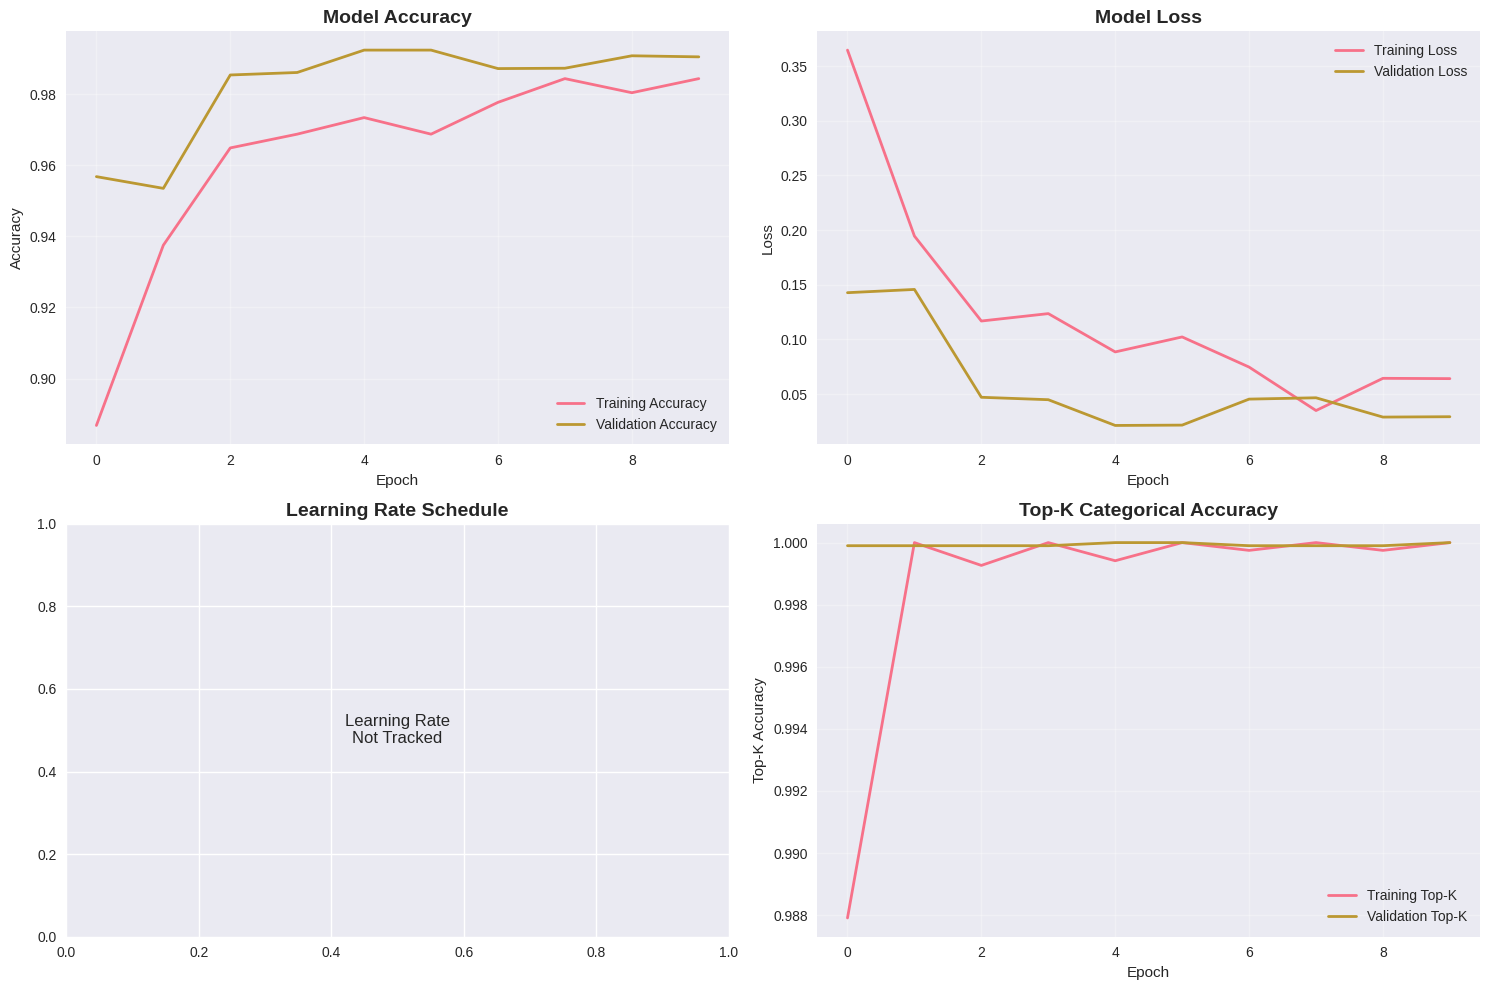


FINAL MODEL EVALUATION

Evaluating model on test set...

Final Test Results:
Test Loss: 0.021397
Test Accuracy: 0.992400 (99.24%)
Top-K Accuracy: 1.000000 (100.00%)

Training Summary:
Epochs Trained: 10
Best Training Accuracy: 0.984375 (98.44%)
Best Validation Accuracy: 0.992400 (99.24%)
Final Test Accuracy: 0.992400 (99.24%)

✅ Good generalization: Training-Test difference: -0.0080


In [8]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation metrics"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy plot
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Loss plot
    axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate (if available)
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'], linewidth=2, color='orange')
        axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Learning Rate\nNot Tracked',
                       ha='center', va='center', transform=axes[1, 0].transAxes,
                       fontsize=12)
        axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')

    # Top-k accuracy (if available)
    if 'top_k_categorical_accuracy' in history.history:
        axes[1, 1].plot(history.history['top_k_categorical_accuracy'],
                       label='Training Top-K', linewidth=2)
        axes[1, 1].plot(history.history['val_top_k_categorical_accuracy'],
                       label='Validation Top-K', linewidth=2)
        axes[1, 1].set_title('Top-K Categorical Accuracy', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Top-K Accuracy')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        # Show epoch vs best validation accuracy
        val_acc = history.history['val_accuracy']
        best_epochs = [i for i, acc in enumerate(val_acc) if acc == max(val_acc)]
        axes[1, 1].plot(range(len(val_acc)), val_acc, linewidth=2)
        axes[1, 1].scatter(best_epochs, [val_acc[i] for i in best_epochs],
                          color='red', s=100, zorder=5, label=f'Best: {max(val_acc):.4f}')
        axes[1, 1].set_title('Validation Accuracy Progress', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Validation Accuracy')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot training history
print("Training History Analysis:")
plot_training_history(history)

# Evaluate model on test set
print("\n" + "="*60)
print("FINAL MODEL EVALUATION")
print("="*60)

print("\nEvaluating model on test set...")
test_results = model.evaluate(x_test, y_test_cat, verbose=0)

# Extract metrics
test_loss = test_results[0]
test_accuracy = test_results[1]
test_top_k = test_results[2] if len(test_results) > 2 else None

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.6f}")
print(f"Test Accuracy: {test_accuracy:.6f} ({test_accuracy*100:.2f}%)")
if test_top_k:
    print(f"Top-K Accuracy: {test_top_k:.6f} ({test_top_k*100:.2f}%)")

# Training summary
final_train_acc = max(history.history['accuracy'])
final_val_acc = max(history.history['val_accuracy'])
epochs_trained = len(history.history['accuracy'])

print(f"\nTraining Summary:")
print(f"Epochs Trained: {epochs_trained}")
print(f"Best Training Accuracy: {final_train_acc:.6f} ({final_train_acc*100:.2f}%)")
print(f"Best Validation Accuracy: {final_val_acc:.6f} ({final_val_acc*100:.2f}%)")
print(f"Final Test Accuracy: {test_accuracy:.6f} ({test_accuracy*100:.2f}%)")

# Check for overfitting
acc_diff = final_train_acc - test_accuracy
if acc_diff > 0.05:
    print(f"\n⚠️  Warning: Possible overfitting detected!")
    print(f"   Training-Test accuracy difference: {acc_diff:.4f}")
else:
    print(f"\n✅ Good generalization: Training-Test difference: {acc_diff:.4f}")



DETAILED CLASSIFICATION ANALYSIS
Generating predictions on test set...

Creating confusion matrix...


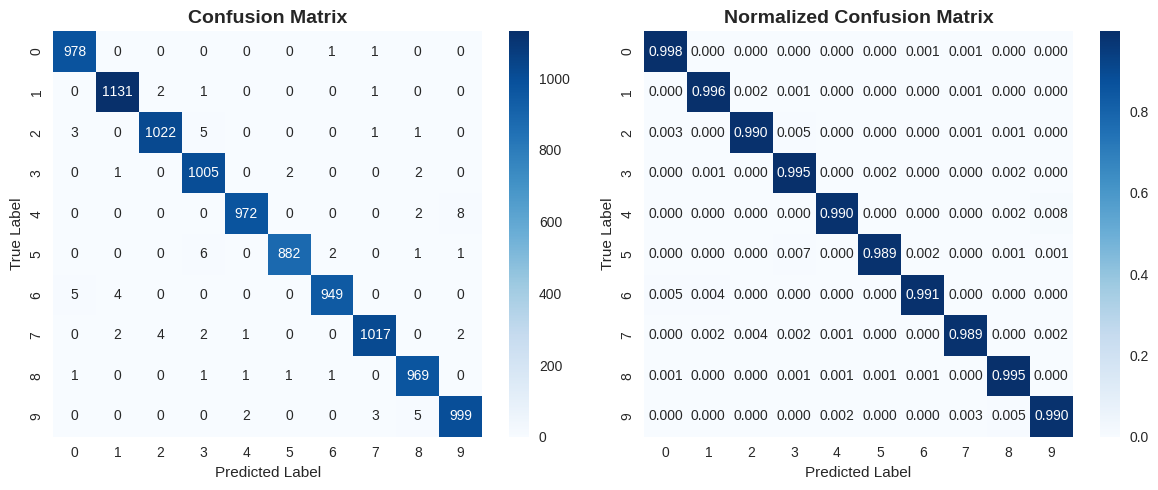


Classification Report:
              precision    recall  f1-score   support

     Digit 0       0.99      1.00      0.99       980
     Digit 1       0.99      1.00      1.00      1135
     Digit 2       0.99      0.99      0.99      1032
     Digit 3       0.99      1.00      0.99      1010
     Digit 4       1.00      0.99      0.99       982
     Digit 5       1.00      0.99      0.99       892
     Digit 6       1.00      0.99      0.99       958
     Digit 7       0.99      0.99      0.99      1028
     Digit 8       0.99      0.99      0.99       974
     Digit 9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


Per-class Accuracy Analysis:
Digit 0: 0.9980 (978/980 correct)
Digit 1: 0.9965 (1131/1135 correct)
Digit 2: 0.9903 (1022/1032 correct)
Digit 3: 0.9950 (1005/1010 correct)
Digit 4: 0.9898 (972/982 correct)
Digit 5: 0.

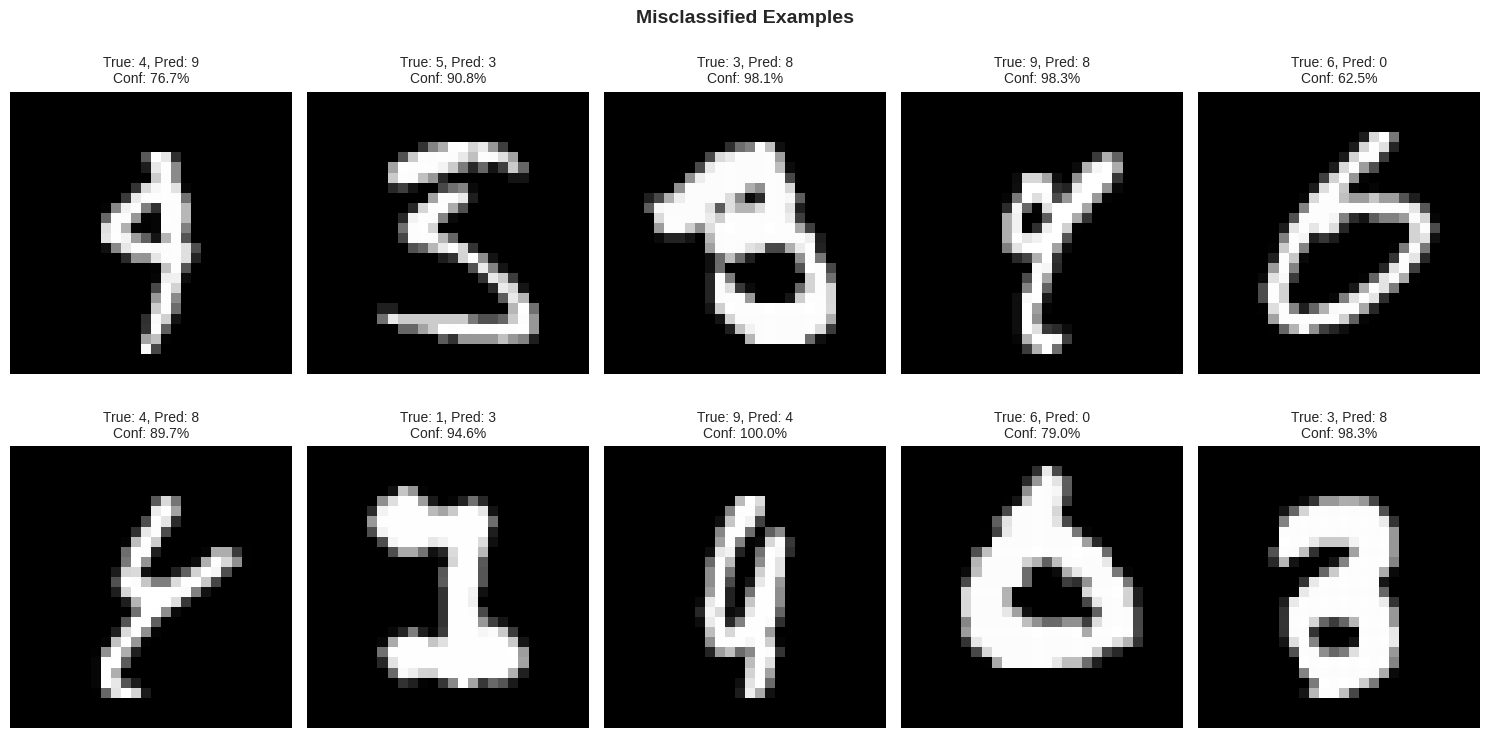

In [9]:
# Detailed classification analysis
print("\n" + "="*60)
print("DETAILED CLASSIFICATION ANALYSIS")
print("="*60)

# Make predictions on test set
print("Generating predictions on test set...")
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Confusion Matrix
print("\nCreating confusion matrix...")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 5))

# Confusion matrix heatmap
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[f'Digit {i}' for i in range(10)]))

# Per-class accuracy analysis
print("\nPer-class Accuracy Analysis:")
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_accuracy):
    total_samples = cm.sum(axis=1)[i]
    correct_predictions = cm.diagonal()[i]
    print(f"Digit {i}: {acc:.4f} ({correct_predictions}/{total_samples} correct)")

# Find most confused pairs
print("\nMost Common Misclassifications:")
confusion_pairs = []
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((i, j, cm[i, j]))

# Sort by confusion count
confusion_pairs.sort(key=lambda x: x[2], reverse=True)
for i, (true_label, pred_label, count) in enumerate(confusion_pairs[:10]):
    percentage = (count / cm.sum(axis=1)[true_label]) * 100
    print(f"{i+1:2d}. Digit {true_label} → {pred_label}: {count:3d} times ({percentage:.1f}%)")

# Error Analysis - Show misclassified examples
def show_misclassified_examples(n_examples=10):
    """Show examples of misclassified digits"""

    # Find misclassified examples
    misclassified_indices = np.where(y_pred != y_test)[0]

    if len(misclassified_indices) == 0:
        print("Perfect classification! No errors found.")
        return

    # Randomly sample misclassified examples
    sample_indices = np.random.choice(misclassified_indices,
                                    min(n_examples, len(misclassified_indices)),
                                    replace=False)

    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(sample_indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_test[idx].squeeze(), cmap='gray')

        true_label = y_test[idx]
        pred_label = y_pred[idx]
        confidence = y_pred_proba[idx][pred_label] * 100

        plt.title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.1f}%',
                 fontsize=10)
        plt.xticks([])
        plt.yticks([])

    plt.suptitle('Misclassified Examples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print(f"\nError Analysis:")
print(f"Total misclassified: {len(np.where(y_pred != y_test)[0])}/{len(y_test)} "
      f"({(len(np.where(y_pred != y_test)[0])/len(y_test)*100):.2f}%)")

show_misclassified_examples(10)

In [ ]:
## 5. Save Final Model and Summary to Google Drive

# Define paths for saving
model_save_path = '/content/drive/My Drive/models/mnist_cnn_model.h5'
model_info_path = '/content/drive/My Drive/models/model_info.txt'

print("="*60)
print("SAVING MODEL TO GOOGLE DRIVE")
print("="*60)

# Save the final model to Google Drive (in case checkpoint didn't save the absolute best)
print(f"\nSaving final model to: {model_save_path}")
model.save(model_save_path)

# Verify the model was saved
if os.path.exists(model_save_path):
    file_size = os.path.getsize(model_save_path) / (1024 * 1024)  # Size in MB
    print(f"✅ Model successfully saved to Google Drive!")
    print(f"   File size: {file_size:.2f} MB")
else:
    print("❌ Error: Model was not saved properly!")

# Save model information and training summary
model_info = f"""MNIST CNN Model Training Summary
=======================================
Date: {str(tf.timestamp())}
TensorFlow Version: {tf.__version__}
Keras Version: {keras.__version__}

Model Architecture:
- Total Parameters: {model.count_params():,}
- Input Shape: (28, 28, 1)
- Output Classes: 10 (digits 0-9)

Training Configuration:
- Epochs Trained: {len(history.history['accuracy'])}
- Batch Size: {BATCH_SIZE}
- Data Augmentation: Yes

Final Performance:
- Test Accuracy: {test_accuracy:.6f} ({test_accuracy*100:.2f}%)
- Test Loss: {test_loss:.6f}
- Best Training Accuracy: {max(history.history['accuracy']):.6f}
- Best Validation Accuracy: {max(history.history['val_accuracy']):.6f}

Model Features:
- Batch Normalization: Yes
- Dropout Regularization: Yes
- Data Augmentation: Yes (rotation, shift, zoom)
- Early Stopping: Yes
- Learning Rate Scheduling: Yes

Usage Instructions:
This model is compatible with the Digit-1.ipynb notebook for real-time digit recognition.
The model expects 28x28 grayscale images normalized to [0,1] range.

Model Path: {model_save_path}
"""

# Save model information
print(f"\nSaving model information to: {model_info_path}")
with open(model_info_path, 'w') as f:
    f.write(model_info)

print(f"✅ Model information saved!")

# Test loading the saved model to ensure compatibility
print(f"\nTesting model loading...")
try:
    loaded_model = keras.models.load_model(model_save_path)
    
    # Quick test prediction
    test_sample = x_test[0:1]  # Take first test sample
    original_pred = model.predict(test_sample, verbose=0)
    loaded_pred = loaded_model.predict(test_sample, verbose=0)
    
    # Check if predictions match
    if np.allclose(original_pred, loaded_pred):
        print("✅ Model loading test passed! The saved model works correctly.")
    else:
        print("⚠️  Warning: Loaded model predictions don't match original model.")
        
except Exception as e:
    print(f"❌ Error loading saved model: {e}")

print("\n" + "="*60)
print("MODEL TRAINING AND SAVING COMPLETE!")
print("="*60)
print(f"\n📁 Your trained model is now available at:")
print(f"   {model_save_path}")
print(f"\n📄 Model information is available at:")
print(f"   {model_info_path}")
print(f"\n🎯 You can now run Digit-1.ipynb to use this model for real-time digit recognition!")
